# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library
# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])


#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

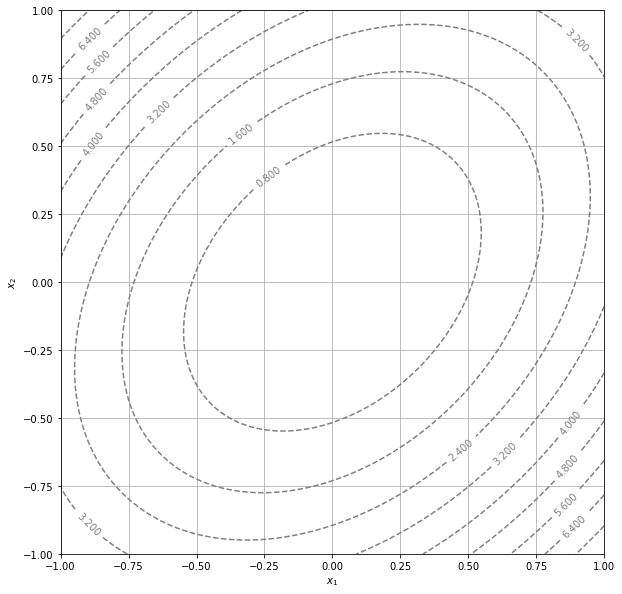

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

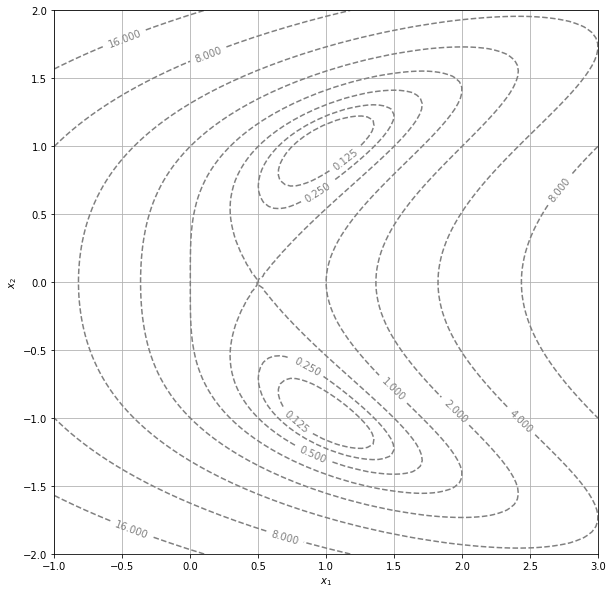

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

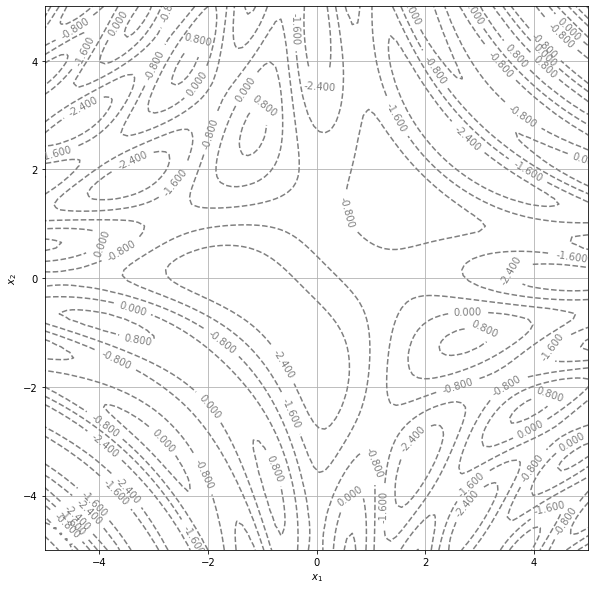

In [13]:
display_contour(
    
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?


#### Réponse :
Notons $E=\left\{ x_1,x_2 | f(x_1,x_2)=c \right\}$. On a :
$f(x_1,x_2)\to +\infty$ quand $\left\| (x_1,x_2) \right\|\to +\infty$.  Ainsi, $\exists \text{ }m_1$ tel que $\forall x_2\in \mathbb{R}\text{ , }\forall \left| x_1 \right|\ge m_1\text{ , }f(x_1,x_2)\gt$  c et $\exists \text{ }m_2$ tel que $\forall x_1\in \mathbb{R}\text{, }\forall \left| x_2 \right|\ge m_2,f(x_1,x_2)\gt c. $   Donc, $E\subset \left[ -m_1,m_1 \right]*\left[ -m_2,m_2 \right] $ D'où E est borné. Soient deux suites $ (x_{1n})_{n} $ et $(x_{2n})_{n}$ telles que $\lim_{n \to \infty }$ $x_{1n} =x_{1}$ et $\lim_{n \to \infty } x_{2n}=x_2 $ et telles que $ \forall n\in \mathbb{N}\text{, } f(x_{1n},x_{2n})=c. $ Par passage à la limite des égalités, $f(x_1,x_2)=c  $ donc E est fermé donc compact.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?


#### Réponse :
Considérons la base orthonormée de $\mathbb{R^{2}}$ suivante : $\overrightarrow{r}$ = $\frac{1}{\left\| \nabla f \right\|}$*$\begin{pmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}\end{pmatrix}$, $\overrightarrow{\tau}$=$\frac{1}{\left\| \nabla f \right\|}$*$\begin{pmatrix}
\frac{\partial f}{\partial y} \\
-\frac{\partial f}{\partial x}\end{pmatrix}$.
Considérons un point $x=\begin{pmatrix}
x_{1} \\
x_{2}
\end{pmatrix}$ de $\mathbb{R^{2}}$:
p est alors le projeté du vecteur $\overrightarrow{x-x_{0}}$ sur $\overrightarrow{\tau}$, c'est à dire sur la tangente:
En effet, $\overrightarrow{x-x_{0}}$.$\overrightarrow{\tau}=p $

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse : 
Soit $\mathcal{V_0}$ un voisinage ouvert de $x_0$ dans lequel le gradient de f ne s'annule pas. On cherche $\varepsilon \gt$ 0 et $\gamma:]-\varepsilon;\varepsilon[\to \mathbb{R}^{2}$ continûment différentiable, tels que :$\\ \forall (x_1,x_2)\in \mathcal{V_0},$ $[f(x_1,x_2)=c\Leftrightarrow (x_1,x_2)=\gamma(t)$ avec $t=p(x_1,x_2)$].


Posons $g:\mathcal{V_0}\times \mathbb{R}\to \mathbb{R}^2;(\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix},t)\longmapsto \begin{bmatrix}
f(x_1,x_2)-c \\
p(x_1,x_2)-t
\end{bmatrix}$. On note $W=\mathcal{V_0}\times\mathbb{R}$

f est continûment différentiable par hypothèse. p l'est aussi comme fonction linéaire en  $x_{1}$ et $x_2$.
Ainsi, g est continûment différentiable. (NB : on note $\frac{\partial g}{\partial x}$ la différentielle partielle par rapport à la première variable).
On a aussi : $\forall (x,t)\in W$, det($\frac{\partial g}{\partial x}(x,t))$ = $\left|  \begin{matrix}
\frac{\partial f}{\partial x_1}(x) & \frac{\partial f}{\partial x_2}(x) \\
 \frac{\partial p}{\partial x_1}(x)& \frac{\partial p}{\partial x_2}(x)
\end{matrix} \right|=\frac{\partial f}{\partial x_1}(x)*\frac{\partial p}{\partial x_2}(x)-\frac{\partial f}{\partial x_2}(x)*\frac{\partial p}{\partial x_1}(x) \\ $Or, $\forall x\in \mathcal{V_0}$, $\frac{\partial p}{\partial x_1}(x)=\frac{1}{\left\| \nabla f(x_{0}) \right\|}\frac
{\partial f}{\partial x_2}(x)$ et $\frac{\partial p}{\partial x_2}(x)=-\frac{1}{\left\| \nabla f(x_{0}) \right\|}\frac{\partial f}{\partial x_1}(x) \\ $Ainsi, $\forall (x,t)\in W$, det($\frac{\partial g}{\partial x}(x,t))=-((\frac{\partial f}{\partial x_1}(x))^{2}+(\frac{\partial f}{\partial x_2}(x))^{2})*\frac{1}{\left\| \nabla f(x_0) \right\|}=-\frac{\left\| \nabla f(x) \right\|^{2}}{\left\| \nabla f(x_0) \right\|}\neq 0$  par hypothèse car le gradient de f ne s'annule pas sur le voisinage $\mathcal{V_0}$ de $x_0$. 
La différentielle partielle $\frac{\partial g}{\partial x}$ est donc inversible sur W.
D'après le théorème des fonctions implicites, comme on a ($\begin{bmatrix}
x_{10} \\x_{20}
\end{bmatrix},p(x_{10},x_{20}))$ qui nous donne $g(\begin{bmatrix}
x_{10} \\x_{20}
\end{bmatrix},p(x_{10},x_{20}))=0$, on en déduit qu'on dispose de $\mathcal{U}$, et $\mathcal{V}=]-\varepsilon;\varepsilon[$ voisinages ouverts de  $x_0$ et $p(x_{10},x_{20})$, tels que $\mathcal{U}\times\mathcal{V}\subset W$,
et on dispose de $\gamma:]-\varepsilon;\varepsilon[\to \mathbb{R}^{2}$ continûment différentiable, telle que : 
$\forall (x_1,x_2)\in \mathcal{V_0}$, $[f(x_1,x_2)=c\Leftrightarrow (x_1,x_2)=\gamma(t)$ avec $t=p(x_1,x_2)$].

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse :
Par la question précédente, on a  $\forall t\in ]-\epsilon;\epsilon[\text{, }f(\gamma(t))=c \\ $ On pose $L=f\circ \gamma $ La composée de deux fonctions continûment différentiables étant continûment dfférentiable, il vient :    $ \forall t\in ]-\epsilon;\epsilon[$ , $L'(t)=\text{ }\lt \gamma'(t),\nabla f(\gamma(t))\gt \text{ }=0 \\$ D'où $\forall t\in ]-\epsilon;\epsilon[$, $\gamma'(t)$ orthogonale à $\nabla f(\gamma(t))$. De même, en exploitant $p(\gamma(t))=t$ et en posant $\forall t\in ]-\epsilon;\epsilon[$, $h(t)=p(\gamma(t))-t$, on obtient $\\ \forall t\in ]-\epsilon;\epsilon[\text{, } h'(t)=0=dp(\gamma(t))\gamma'(t)-1$. D'où $\forall t\in ]-\epsilon;\epsilon[, \gamma'(t)\neq 0$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

#### Réponse :
Afin de déterminer un ordre de grandeur de $\varepsilon$, on raisonne sur la précision de l'affichage. En prenant un écran de 13 pouces (ce qui correspond à 33cm horizontaux) et avec 1366 pixels de longueur, on a donc 1366/33=41 pixels par centimètre. On mesure ensuite la place prise par une unité de graphique. On constate qu'elle prend une place de 41 pixels. On peut donc prendre $\varepsilon=1/41=0,02$ qui est le nombre d'unités par pixel. on prend donc : $ \\ $
eps = 0.02,
N=1000

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
from scipy import linalg

# Tâche 1 :


def Newton(F, x0, y0, eps, N):
    J_f = J(F)
    U = np.array([x0, y0])
    V = linalg.inv(J_f(x0, y0)).dot(J_f(x0, y0).dot(U)-F(U[0], U[1]))
    for i in range(N):
        U, V = V, V-linalg.inv(J_f(V[0], V[1])).dot(F(V[0], V[1]))
        x = V[0]
        y = V[1]
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")



#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

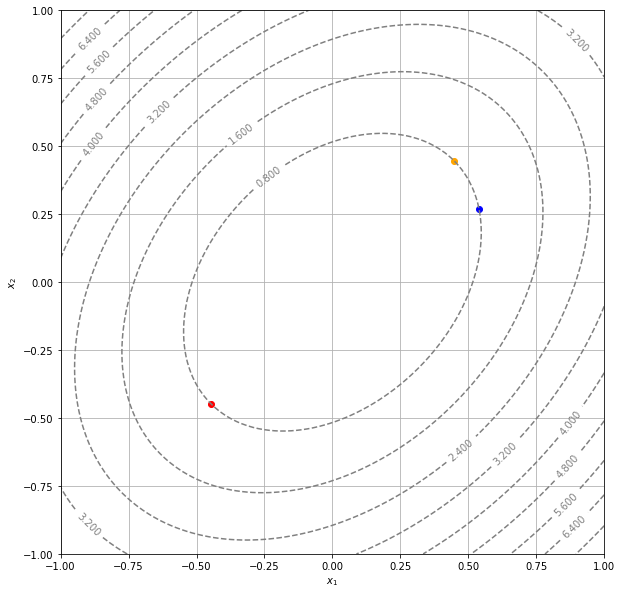

In [17]:
# On teste avec la fonction de référence :


def F1(x1, x2):
    def f1(x1, x2):
        x1 = np.array(x1)
        x2 = np.array(x2)
        return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2
    global c
    return np.array([f1(x1, x2)-c, x1-x2])  # F1 tient compte de la contrainte x1 = x2


c = 0.8

Point1 = Newton(F1, 0.8, 0.8, 0.02, 1000)
Point2 = Newton(F1, -0.5, -0.25, 0.02, 1000)
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10  # 10 levels, automatically selected
)
plt.scatter(Point1[0], Point1[1], c='orange')
plt.scatter(Point2[0], Point2[1], c='red')

# Changeons de contrainte supplémentaire :
def F1_bis(x1,x2):
    def f1(x1, x2):
        x1 = np.array(x1)
        x2 = np.array(x2)
        return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2
    global c
    return np.array([f1(x1, x2)-c, x1-2*x2])


Point3= Newton(F1_bis, 0.5, 0.25, 0.02, 1000)
plt.scatter(Point3[0], Point3[1], c='blue')

plt.show()

# Notre fonction Newton semble donc bien fonctionner


### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

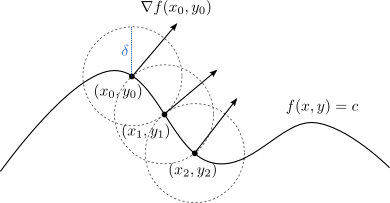

#### Réponse :
On considère le vecteur $\overrightarrow{D2}$ de norme $\delta$ et orthogonal au gradient de f en $(x_0, y_0)$, pointant vers la "droite" : en notant $\overrightarrow{\nabla}(f)(x_0, y_0)=\begin{bmatrix}
g1 \\
g2
\end{bmatrix}$, on a $\overrightarrow{D2}=\begin{bmatrix}
g2 \\ 
-g1
\end{bmatrix}*\frac{\delta}{\left\| \overrightarrow{\nabla }(f)(x_0, y_0) \right\|}$.
En posant $X1=(x_0, y_0)+\overrightarrow{D2}$, on a alors ce point $X1$ qui est sur le cercle de rayon $\delta$ et de centre $(x_0,y_0)$. Il n'est pas forcément sur la courbe de niveau, mais comme on s'est déplacé orthogonalement au gradient, on n'en est pas "loin" a priori. Pour que le point retourné soit sur la courbe de niveau, on applique Newton avec comme point de départ X1, et en définissant Fc prenant comme contrainte $(x_1-x_0)^{2}+(y_1-y_0)^{2}=\delta^{2}$ :

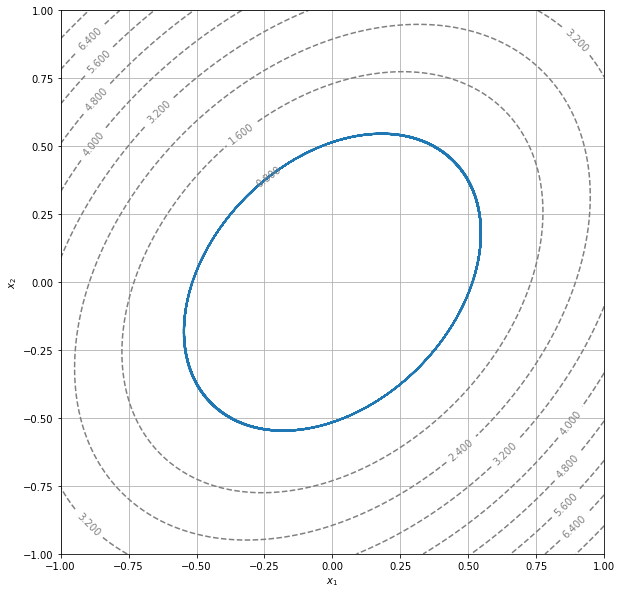

In [20]:
def level_curve(f, x0, y0, delta, N, eps):
    def Fc(x1, y1):  #on crée la fonction avec la contrainte
        global c
        return np.array([f(x1, y1)-c, ((x1-x0)**2)+((y1-y0)**2)-delta**2])
    Points = np.zeros((2, N))
    grad_f = grad(f)
    for i in range(N):
        D = grad_f(x0, y0)/np.linalg.norm(grad_f(x0, y0))*delta
        D2 = np.array([D[1], -D[0]])
        x = Newton(Fc, x0+D2[0], y0+D2[1], eps, N)[0]
        y = Newton(Fc, x0+D2[0], y0+D2[1], eps, N)[1]
        Points[0][i] = x
        Points[1][i] = y
        x0, y0 = x, y
    return Points


c = 0.8

# On teste maintenant avec les 3 fonctions de référence :
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    a = 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2
    return a


A = level_curve(f1, -0.05, 0.5, 0.1, 1000, 0.02)

display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 100),
    y=np.linspace(-1.0, 1.0, 100),
    levels=10)  # 10 levels, automatically selected

plt.plot(A[0], A[1])
plt.show()

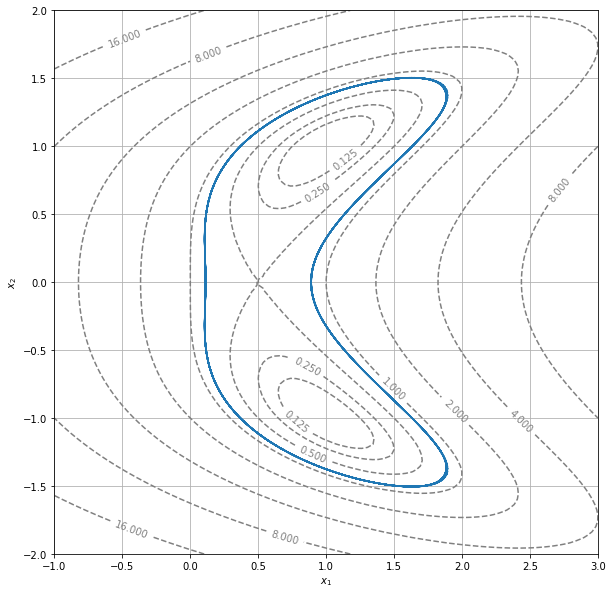

In [19]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2


display_contour(
    f2,
    x=np.linspace(-1.0, 3.0, 100),
    y=np.linspace(-2.0, 2.0, 100),
    levels=[2**i for i in range(-3, 8)])   # levels: [0.125, 0.25, ..., 64, 128]


B = level_curve(f2, 1., -1.35, 0.1, 1000, 0.02)
plt.plot(B[0], B[1])
plt.show()

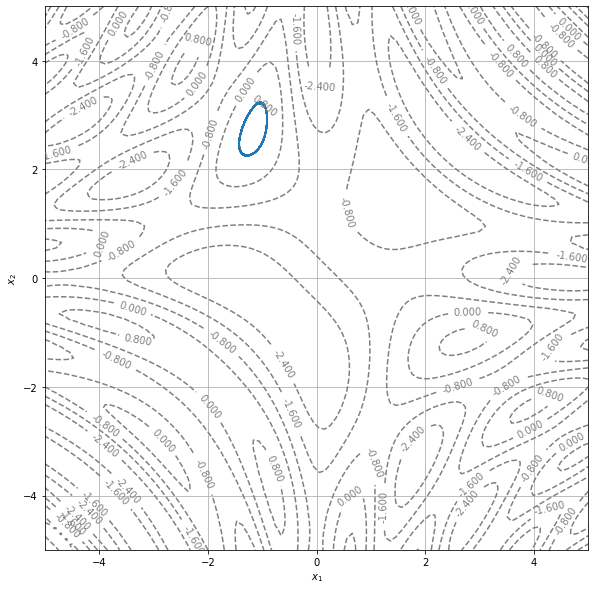

In [21]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)


display_contour(
    f3,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5)  # 5 levels, automatically selected
C = level_curve(f3, -1.5, 2.5, 0.1, 1000, 0.2)
plt.plot(C[0], C[1])
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse :
Le cas du point (0.5,0) de la fonction de Rosenbrock est très rare. En effet, ce cas arrive quand le gradient de la fonction s'annule (il est orthogonal aux deux lignes de niveau en ce point, donc nécessairement nul), mais que l'on a pas d'extremum local en ce point. On peut donc considérer suffisamment rare pour ne pas en tenir compte. Et lorsqu'il n'y a pas d'auto-intersection, un nouveau segment ne peut croiser un des précédents autre que le premier.

In [22]:
def level_curve_bis(f, x0, y0, delta, N, eps):
    def Fc(x1, y1):
        global c
        return np.array([f(x1, y1) - c, ((x1-x0)**2) + ((y1-y0)**2) - delta**2])
    Points = np.zeros((2, N))
    grad_f = grad(f)
    for i in range(N):
        D = grad_f(x0, y0)/np.linalg.norm(grad_f(x0, y0))*delta
        D2 = np.array([D[1], -D[0]])
        x = Newton(Fc, x0+D2[0], y0+D2[1], eps, N)[0]
        y = Newton(Fc, x0+D2[0], y0+D2[1], eps, N)[1]
        # On teste si il y a intersection avec le premier segment :
        if i > 2: # A partir du 3ème segment, avant il ne peut y avoir intersection
            x0 = Points[0][0]  # [X0, X1] constitue le premier segment, 
            y0 = Points[1][0]
            x1 = Points[0][1]
            y1 = Points[1][1]
            x_1 = Points[0][i-1]  # [X_1, X] constitue le dernier segment formé
            y_1 = Points[1][i-1]
            if max(min(x_1, x), min(x0, x1)) <= min(max(x_1, x), max(x0, x1)) and max(min(y_1, y), min(y0, y1)) <= min(max(y_1, y), max(y0, y1)):
                Points[0][i] = x
                Points[1][i] = y
                return Points[:, 0:i+1]
        Points[0][i] = x
        Points[1][i] = y
        x0, y0 = x, y
    return Points

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

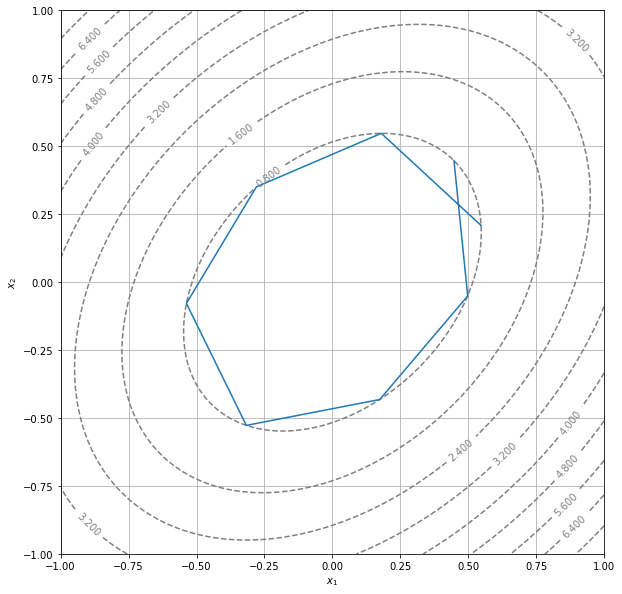

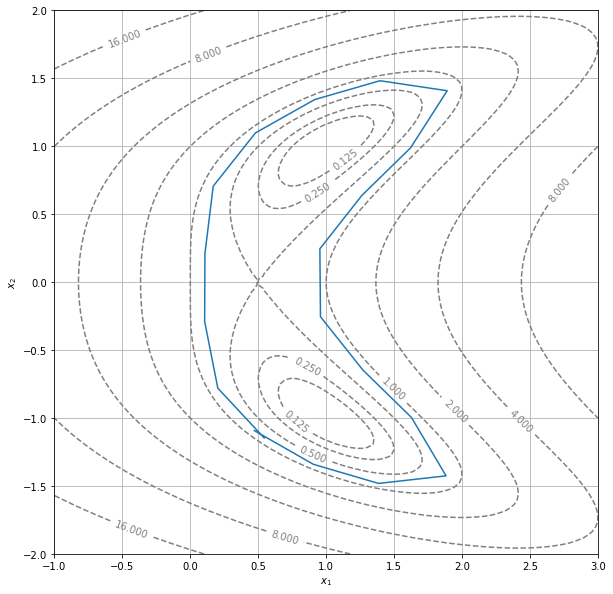

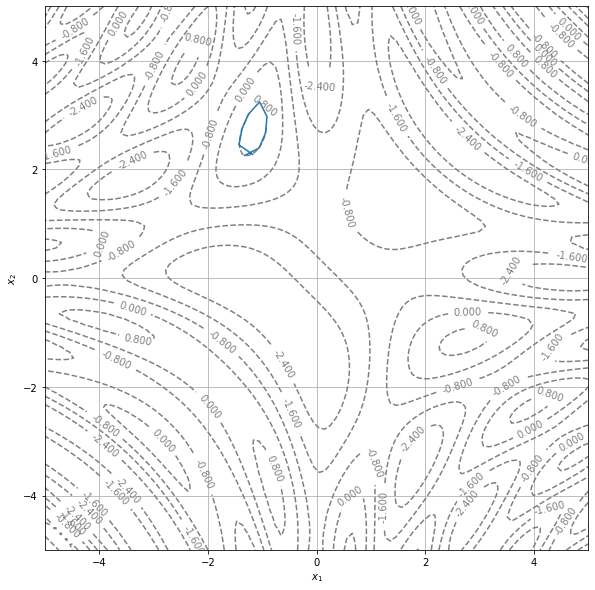

In [23]:
A = level_curve_bis(f1, -0.05, 0.5, 0.5, 1000, 0.02)

display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 100),
    y=np.linspace(-1.0, 1.0, 100),
    levels=10)  # 10 levels, automatically selected

plt.plot(A[0], A[1])
plt.show()


def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2


display_contour(
    f2,
    x=np.linspace(-1.0, 3.0, 100),
    y=np.linspace(-2.0, 2.0, 100),
    levels=[2**i for i in range(-3, 8)])  # levels: [0.125, 0.25, ..., 64, 128]


B = level_curve_bis(f2, 1., -1.35, 0.5, 1000, 0.02)
plt.plot(B[0], B[1])
plt.show()


def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)


display_contour(
    f3,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5)  # 5 levels, automatically selected
C = level_curve_bis(f3, -1.5, 2.5, 0.3, 1000, 0.2)
plt.plot(C[0], C[1])
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse :
Posons, pour $t\in [0,1]$, $Z(t) = \begin{bmatrix}
x(t) \\
y(t)
\end{bmatrix} = X_0 + X_1*t + X_2*t^{2}$ avec $X_0 = \begin{bmatrix}
a \\
d
\end{bmatrix}, X1 = \begin{bmatrix}
b \\
e
\end{bmatrix}$
 et $X_2 = \begin{bmatrix}
c \\
f
\end{bmatrix}$
On a $P1=Z(0)$ donc $P1=X_0$. On en déduit alors a et d. Et $Z(1)=X_0+X_1+X_2=P2$ donc $P2-P1=X_1+X_2$ $\\$
Par ailleurs, supposons que l'on ait une solution. Posons alors $\lambda$ tel que  $Z'(0)=$\lambda$*$u_1$, et $\mu$  tel que Z'(1)= $\mu$*$u_2$.
On a alors $X_1=\lambda*u_1$, et $\mu*u_2=X_1+2*X_2$, d'où $2*(X_1+X_2)=\lambda*u_1+\mu*u_2$
Donc $\textbf{(A)}$ : $ 2*(P_2-P_1)=\lambda*u_1+\mu*u_2$. Si ($u_1$, $u_2$) forme une famille libre de $\mathbb{R}^{2}$, on trouve facilement l'unique couple ($\lambda,\mu$), qui vérifie la relation (A). On trouve ensuite les coefficients b, e, c et f avec les relations explicitées précédemment.
Si $u_1$ et $u_2$ sont colinéaires, si $P_2-P_1$ n'est pas colinéaire à $u_1$ (ou $u_2$), alors (A) ne peut-être vérifiée quelquesoient $\lambda$ et $\mu$. On en déduit qu'on n'a pas de solution. 
Remarque :  on ne traite pas le cas où $P_2-P_1$ est colinéaire à $u_1$ et $u_2$, ce dernier n'étant a priori jamais réalisé puisque l'on a des doubles et qu'une égalité parfaite semble improbable.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




In [24]:
def gamma(t, P1, P2, u1, u2):
    if u1[0]*u2[1]-u1[1]*u2[0] != 0:  # si u1 et u2 forment une famille libre
        P = np.array([[u1], [u2]]).reshape(2, 2).T
        l = np.dot(np.linalg.inv(P), 2*(P2-P1))[0]
        m = np.dot(np.linalg.inv(P), 2*(P2-P1))[1]
        a = P1[0]
        d = P1[1]
        b = l*u1[0]
        e = l*u1[1]
        c = (m*u2[0]-b)/2.
        f = (m*u2[1]-e)/2.
        X = a+b*t+c*(t**2)
        Y = d+e*t+f*(t**2)
    else:
        if P2[0]-P1[0] != 0:
            X = np.linspace(P1[0], P2[0], len(t))
            Y = ((P2[1]-P1[1])/(P2[0]-P1[0]))*(X-P1[0])+P1[1]
        else:
            return np.array([P1[0]*len(t), np.linspace(P1[1], P2[1], len(t))])
    return np.array([X, Y]).reshape(2, len(t))
    

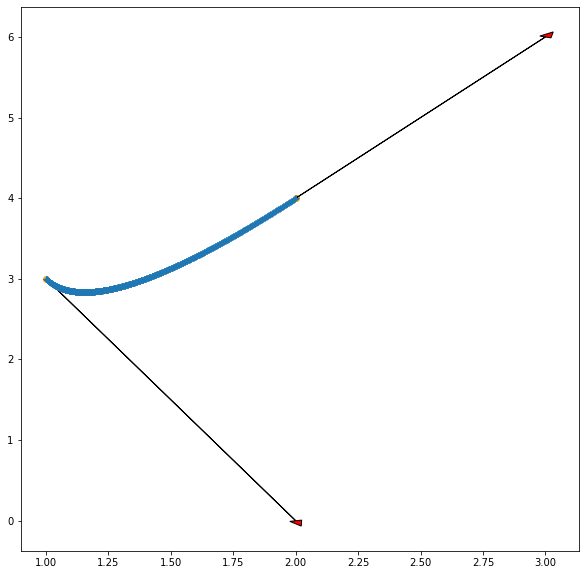

In [25]:
ax = plt.axes()

# représentons :
u1 = np.array([1., 2.]).reshape(2, 1)
u2 = np.array([1., -3.]).reshape(2, 1)
P1 = np.array([2., 4.]).reshape(2, 1)
P2 = np.array([1., 3.]).reshape(2, 1)
X, Y = gamma(np.linspace(0, 1, 1000), P1, P2, u1, u2)

plt.plot(X, Y, marker='+')
ax.arrow(float(P1[0]), float(P1[1]), float(u1[0]),
         float(u1[1]), head_width=0.05, head_length=0.07, fc='red', ec='black')
ax.arrow(float(P2[0]), float(P2[1]), float(u2[0]),
         float(u2[1]), head_width=0.05, head_length=0.07, fc='red', ec='black')
plt.scatter(float(P1[0]), float(P1[1]), c='orange')
plt.scatter(float(P2[0]), float(P2[1]), c='orange')
plt.show()



### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [26]:
def level_curve_ter(f, x0, y0, delta, N, eps, oversampling):
    def Fc(x1, y1):
        global c
        return np.array([f(x1, y1)-c, ((x1-x0)**2)+((y1-y0)**2)-delta**2])
    grad_f = grad(f)
    if oversampling == 1:
        return level_curve_bis(f, x0, y0, delta, N, eps)
    elif oversampling > 1:
        n = oversampling-1
        Points = level_curve_bis(f, x0, y0, delta, N, eps)
        N2 = np.shape(Points)[1]
        Points_tot = np.zeros((2, (N2-1)*(n+1)+1))
        k = 0
        while k < N2-1:
            Points_tot[0][k*(n+1)] = Points[0][k]
            Points_tot[1][k*(n+1)] = Points[1][k]
            P1 = np.array([[Points[0][(k)]], [Points[1][k]]])
            P2 = np.array([[Points[0][k+1]], [Points[1][k+1]]])
            grad1 = grad_f(Points[0][k], Points[1][k])
            grad2 = grad_f(Points[0][k+1], Points[1][k+1])
            u1 = np.array([[grad1[1]], [-grad1[0]]])
            u2 = np.array([[grad2[1]], [-grad2[0]]])
            Points_int = gamma(np.linspace(0, 1, n), P1, P2, u1, u2)
            Points_tot[:, k*(n+1)+1:(k+1)*(n+1)] = Points_int
            k += 1
        Points_tot[0][(N2-1)*(n+1)] = Points[0][N2-1]
        Points_tot[1][(N2-1)*(n+1)] = Points[1][N2-1]
        return Points_tot
    elif oversampling < 1:
        return 'error'

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

On poursuit avec les mêmes courbes de niveau à c=0.8 :

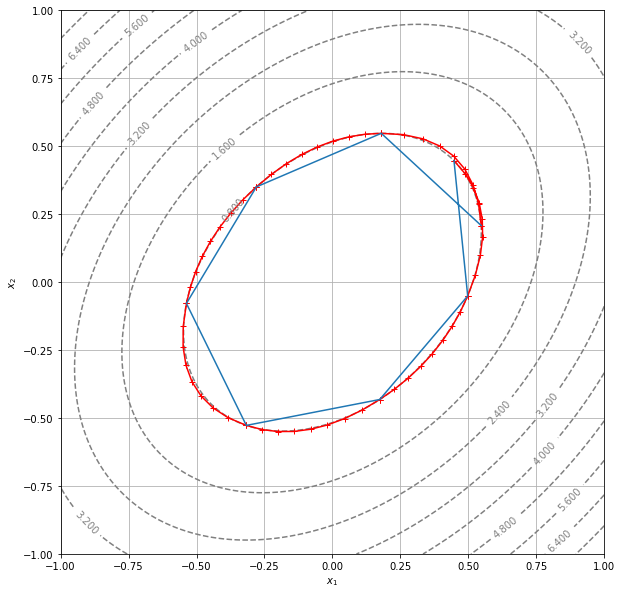

In [27]:
Point = level_curve_ter(f1, -0.05, 0.5, 0.5, 1000, 0.02, 10)

display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 1000),
    y=np.linspace(-1.0, 1.0, 1000),
    levels=10)  # 10 levels, automatically selected
plt.plot(Point[0], Point[1], color='r', marker='+')
A = level_curve_bis(f1, -0.05, 0.5, 0.5, 1000, 0.02)
plt.plot(A[0], A[1])
plt.show()

# On voit bien l'effet du lissage, très efficace 

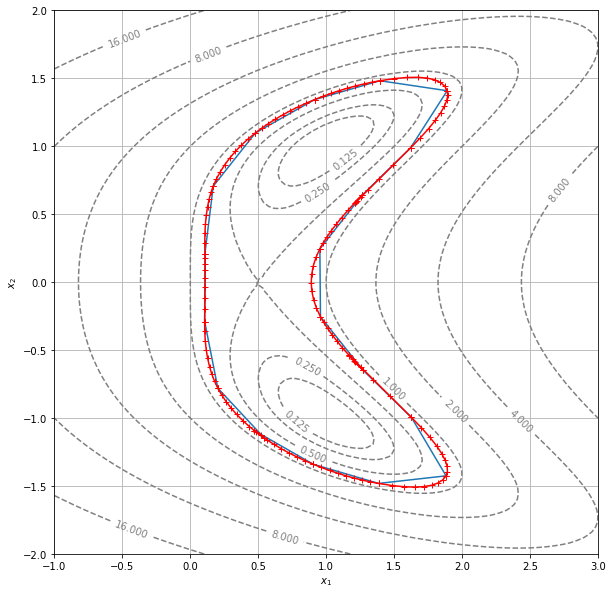

In [28]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2


display_contour(
    f2,
    x=np.linspace(-1.0, 3.0, 100),
    y=np.linspace(-2.0, 2.0, 100),
    levels=[2**i for i in range(-3, 8)])  # levels: [0.125, 0.25, ..., 64, 128]

B = level_curve_ter(f2, 1., -1.35, 0.5, 1000, 0.02, 10)
B2 = level_curve_bis(f2, 1., -1.35, 0.5, 1000, 0.02)
plt.plot(B2[0], B2[1])
plt.plot(B[0], B[1], color='r', marker='+')
plt.show()

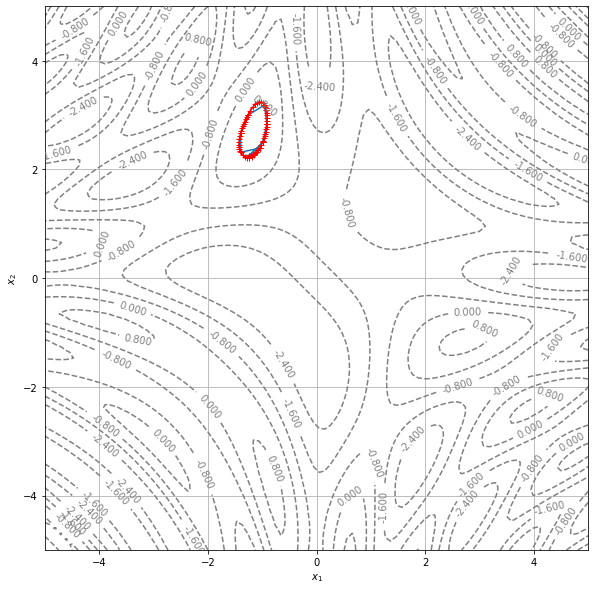

In [29]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y)


display_contour(
    f3,
    x=np.linspace(-5.0, 5.0, 100),
    y=np.linspace(-5.0, 5.0, 100),
    levels=5)  # 5 levels, automatically selected
C = level_curve_ter(f3, -1.5, 2.5, 0.35, 1000, 0.2, 10)
C2 = level_curve_bis(f3, -1.5, 2.5, 0.35, 1000, 0.2)
plt.plot(C2[0], C2[1])
plt.plot(C[0], C[1], color='r', marker='+')
plt.show()